# Inlet Profiles

Chromatographic systems always require some kind of convective flow through the column. 

In this lesson, we will:
- Create and connect our first systems of unit operations.
- Define inlet profiles using piecewise cubic polynomials.
- Run CADET and analyze the results.

## Example 1: Flow from INLET to OUTLET

In a first example, we will look at a simple system with just two unit operations, an [INLET](https://cadet.github.io/master/modelling/unit_operations/inlet), and an [OUTLET](https://cadet.github.io/master/modelling/unit_operations/outlet).

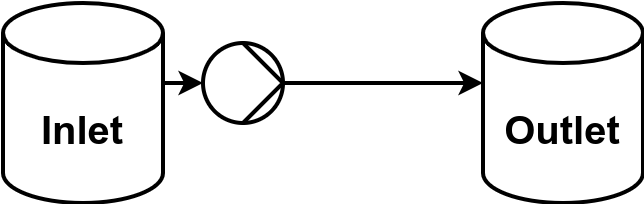

We will introduce flow from the `INLET` to the `OUTLET` with a constant flow rate of $Q = 1~mL \cdot s^{-1}$. 
In the first section, the concentration is $1.0~mM$, and after $1~min$, it is changed to $0.0~mM$.

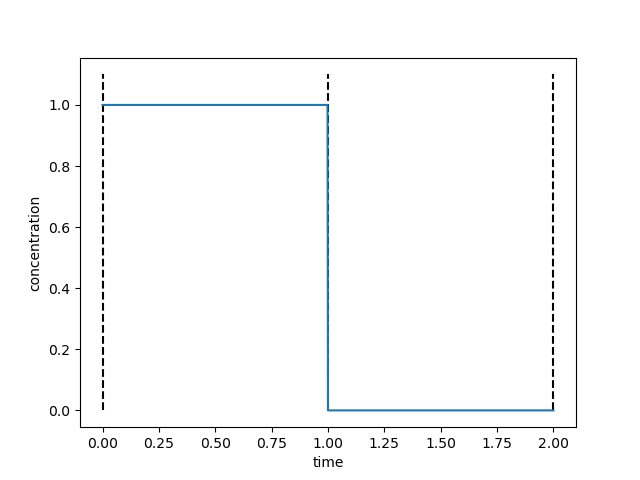

### 1. Setting up the model

Before we start with specifying the system, we define some local auxiliary variables.
Note that we have to convert all units to SI units.

<div class="alert alert-info">

**Note:** 
    
Generally, CADET can be used with any consistent system of units.
However, we strongly recommend converting everything to the SI system.
    
</div>

#### Component System

First, a `ComponentSystem` needs to be created.
The `ComponentSystem` ensures that all parts of the process have the same number of components.
Moreover, components can be named which automatically adds legends to the plot methods.
For advanced use, see [here](https://cadet-process.readthedocs.io/en/latest/reference/process_model/component_system.html).

In this case, it is simple to setup; only the number of components needs to be specified.

In [1]:
from CADETProcess.processModel import ComponentSystem

component_system = ComponentSystem(1)

Alternatively, pass a list of strings for the component names in the constructor:

In [2]:
component_system = ComponentSystem(['A'])

#### Unit Operations

Now, the unit operation models are instantiated.
For an overview of all models in CADET-Process, see [here](https://cadet-process.readthedocs.io/en/latest/reference/process_model/unit_operation_models.html).

To instantiate a unit, it requires the component system, as well as a unique name.
Note that the name string passed in the constructor is later used to reference the unit in the flow sheet for setting `Events` and `OptimizationVariables`.

##### Inlet

In CADET, the `Inlet` pseudo unit operation serves as source for the system and is used to create arbitary concentration profiles as boundary conditions (see also [here](https://cadet.github.io/master/modelling/unit_operations/inlet)).

The concentration profile is described using a third degree piecewise polynomial for each component. 
Later, we will define the pieces, when we look at events.
Similarly, the flow rate can be expressed as a third degree piecewise polynomial.
Since the flow rate is constant, we can directly set the parameter on the object.

In [3]:
from CADETProcess.processModel import Inlet

inlet = Inlet(component_system, 'inlet')
inlet.flow_rate = 1e-6

Note that every unit operation model has different model parameters.
To display all parameters, simply print the `parameters` attribute.

In [4]:
print(inlet.parameters)

{'flow_rate': array([1.e-06, 0.e+00, 0.e+00, 0.e+00]), 'c': array([[0., 0., 0., 0.]])}


##### Outlet
The `Outlet` is another psuedo unit operation that serves as sink for the system (see also [here](https://cadet.github.io/master/modelling/unit_operations/outlet)).

In [5]:
from CADETProcess.processModel import Outlet

outlet = Outlet(component_system, 'outlet')

Note that the `Outlet` unit does not have any model parameters.

In [6]:
print(outlet.parameters)

{}


#### Setting up FlowSheet

To represent the flow between different unit operations, a `FlowSheet` object is initiated. All units need to be added and then connected accordingly. For more information, see also [here](https://cadet-process.readthedocs.io/en/latest/reference/process_model/flow_sheet.html).

In [7]:
from CADETProcess.processModel import FlowSheet

flow_sheet = FlowSheet(component_system)

flow_sheet.add_unit(inlet)
flow_sheet.add_unit(outlet)

flow_sheet.add_connection(inlet, outlet)

#### Define Dynamic Events in Process

The `Process` class is used to define dynamic changes to of the units and connections.
After instantiation, it is important to also set the overall duration of the process.
Since CADET-Process is also designed for cyclic processes, the corresponding attribute is called `cycle_time`.

In [8]:
from CADETProcess.processModel import Process

process = Process(flow_sheet, 'process')
process.cycle_time = 120

The `add_event` method requires the following arguments:
- `name`: Name of the event.
- `parameter_path`: Path of the parameter that is changed in dot notation. E.g. the flow rate of the eluent unit is the parameter `flow_rate` of the `eluent` unit in the `flow_sheet`. Hence, the path is `flow_sheet.eluent.flow_rate`. As previously mentioned, the name of the unit operation is used to reference it, not the variable.
- `state`: Value of the attribute that is changed at Event execution.
- `time`: Time at which the event is executed.

To display all section dependent parameters of an object, use the `section_dependent_parameters` attribute.

In [9]:
print(inlet.section_dependent_parameters)

{'flow_rate': array([1.e-06, 0.e+00, 0.e+00, 0.e+00]), 'c': array([[0., 0., 0., 0.]])}


Note that also flow sheet connectivity can be added as events. More on that later.

In [10]:
print(process.flow_sheet.section_dependent_parameters)

{'inlet': {'flow_rate': array([1.e-06, 0.e+00, 0.e+00, 0.e+00]), 'c': array([[0., 0., 0., 0.]])}, 'output_states': {'inlet': [1], 'outlet': []}, 'outlet': {}}


In [11]:
_ = process.add_event('start load', 'flow_sheet.inlet.c', [1], 0)
_ = process.add_event('start wash', 'flow_sheet.inlet.c', [0], 60)

## 3. Setting up the simulator and running the simulation

To simulate the process, a process simulator needs to be configured.
If no path is specified, CADET-Process will try to autodetect CADET.

In [12]:
from CADETProcess.simulator import Cadet
process_simulator = Cadet()

If a specific version of CADET is to be used, add the install path to the constructor:

```
process_simulator = Cadet(install_path='/path/to/cadet/executable')
```

To check that everything works correctly, you can call the check_cadet method:

In [13]:
process_simulator.check_cadet()

Test simulation completed successfully


Now, run the simulation:

In [14]:
simulation_results = process_simulator.simulate(process)

## 4. Plotting the results

The simulation_results object contains the solution for the inlet and outlet of every unit operation also provide plot methods.

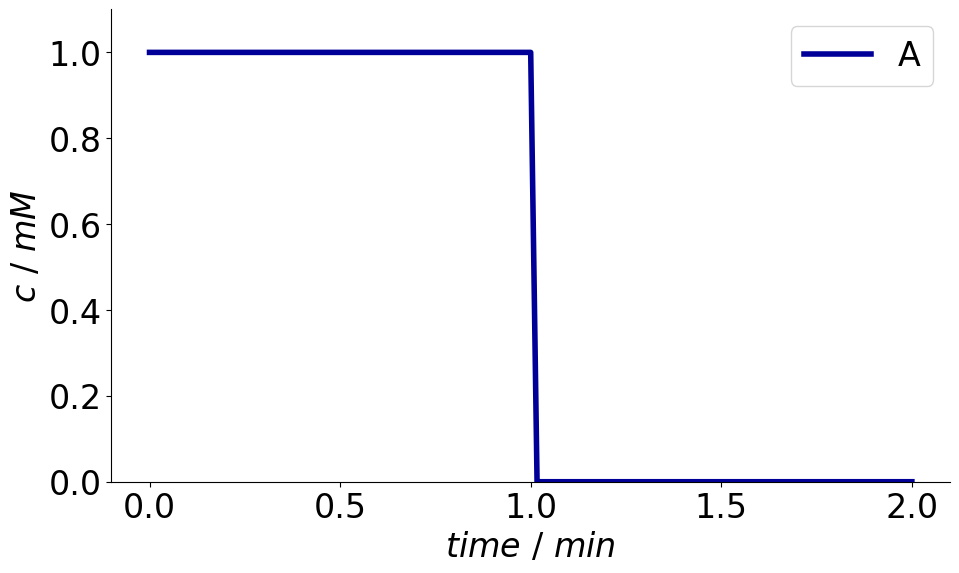

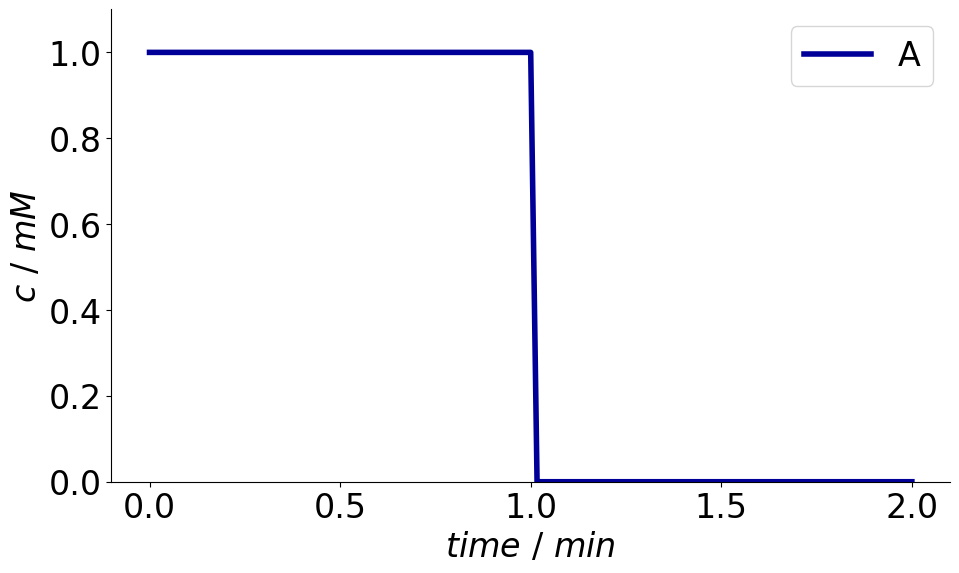

In [15]:
_ = simulation_results.solution.inlet.outlet.plot()
_ = simulation_results.solution.outlet.inlet.plot()